In [1]:
#!conda install plotly
%config IPCompleter.greedy=True  


In [2]:
# Let us load in the relevant Python modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [3]:
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data\sample_submission.csv
./data\test.csv
./data\train.csv


In [4]:
train = pd.read_csv("./data/train.csv")
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
# Taking a look at how many rows and columns the train dataset contains
rows = train.shape[0]
columns = train.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


In [6]:
train.isnull().any().any()

False

In [7]:
'''여기서 False가 나오니 null값이 없다고 볼 수 있다. 하지만 '-1' 값이 들어있으면 해당 변수를 결측치로 본다고 정보란에 적혀 있다.

따라서 '-1'값을 NaN으로 변환하여 처리하려고 한다.'''
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

In [8]:
train_copy.isnull().any().any()

True

<AxesSubplot:>

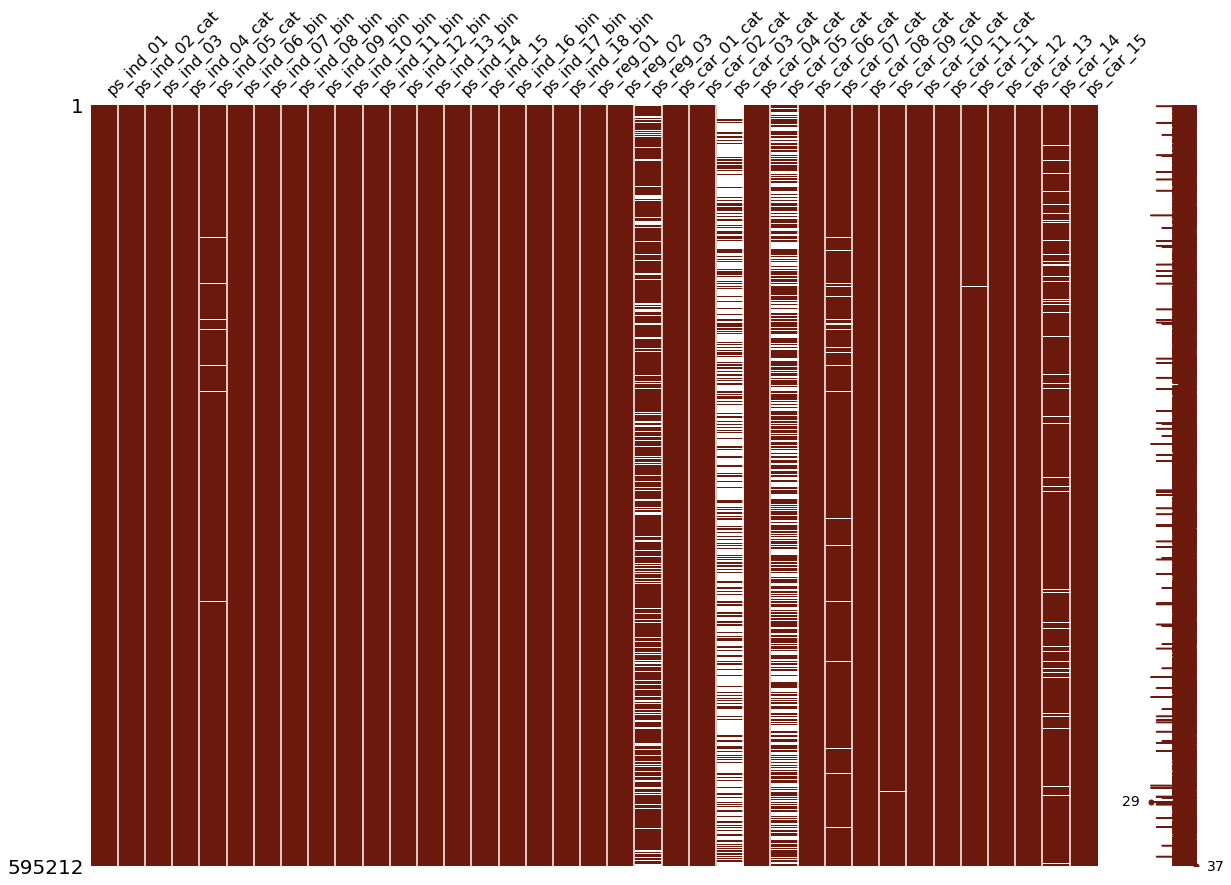

In [9]:
import missingno as msno
msno.matrix(df=train_copy.iloc[:, 2:39], figsize=(20,14), color=(0.42, 0.1, 0.05))

In [10]:
data = [go.Bar(
            x = train["target"].value_counts().index.values,
            y = train["target"].value_counts().values,
            text='Distribution of target variable'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [11]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

In [12]:
#상관계수
#[ 피어슨 상관계수 ( Pearson Correlation Coefficient) ]

train_float.corr()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
ps_reg_01,1.000000,0.471027,0.637035,0.018802,0.027097,0.012704,0.002765,-0.000891,0.002194,-0.001538
ps_reg_02,0.471027,1.000000,0.516457,0.171416,0.194316,0.004147,0.054510,0.001347,-0.000770,0.000022
ps_reg_03,0.637035,0.516457,1.000000,0.082578,0.099415,0.006271,0.022930,-0.001484,0.002147,-0.000401
ps_car_12,0.018802,0.171416,0.082578,1.000000,0.671720,0.012395,0.049882,-0.000700,-0.000427,0.000172
ps_car_13,0.027097,0.194316,0.099415,0.671720,1.000000,-0.037310,0.529519,0.000157,0.000040,-0.000200
ps_car_14,0.012704,0.004147,0.006271,0.012395,-0.037310,1.000000,-0.033060,-0.001191,0.001217,0.000433
ps_car_15,0.002765,0.054510,0.022930,0.049882,0.529519,-0.033060,1.000000,0.000344,-0.000252,-0.001043
ps_calc_01,-0.000891,0.001347,-0.001484,-0.000700,0.000157,-0.001191,0.000344,1.000000,-0.002418,0.000526
ps_calc_02,0.002194,-0.000770,0.002147,-0.000427,0.000040,0.001217,-0.000252,-0.002418,1.000000,0.002948
ps_calc_03,-0.001538,0.000022,-0.000401,0.000172,-0.000200,0.000433,-0.001043,0.000526,0.002948,1.000000


<AxesSubplot:title={'center':'Pearson correlation of continuous features'}>

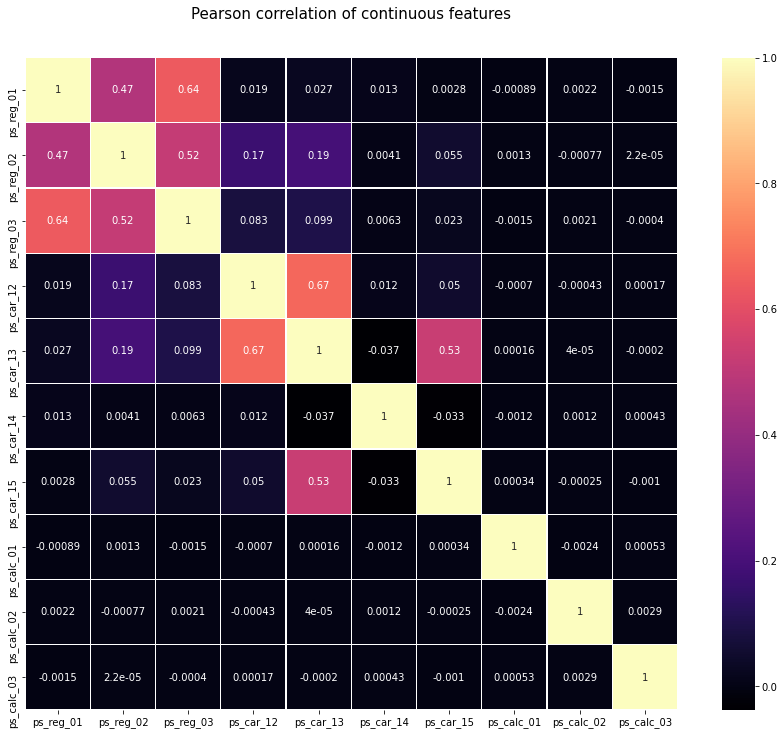

In [13]:
# 실수형 변수의 상관관계 heatmap

colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True,
           cmap=colormap, linecolor='white', annot=True)

In [14]:
# 정수형 변수의 상관관계
data = [
    go.Heatmap(
        z = train_int.corr().values,
        x = train_int.columns.values,
        y = train_int.columns.values,
        colorscale = 'Viridis',
        reversescale = False,
        opacity = 1.0 )
]

layout = go.Layout(
    title = 'Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

In [15]:
'''상호정보량 Mutual Information plots
상호정보량은 타겟변수와 그에 상응하는 변수들의 상호 관계를 확인할 수 있는 유용한 기법 중 하나이다.
sklearn의 mutual_info_classif 방법을 사용하여 두가지 랜덤 변수의 의존성을 측정한다.
이는 타겟 변수가 다른 변수들 사이에서 얼마나 많은 정보를 가지고 있는 지 확인할 수 있다.

그러나 실제로는 매우 심플한 이론이다.


사건 A가 일어날 확률 : P(A)

사건 B가 일어날 확률 : P(B)



이라고 할 때, 

사건 A와 사건 B의 상호정보량은 아래와 같다.

      MI(A,B) = P(A∩B) / ( P(A)*P(B) )

출처: https://shineware.tistory.com/entry/상호정보량Mutual-Information [To. Me]

'''

mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors=3, random_state=17)
print(mf)

[0.01402035 0.00431986 0.0055185  0.00778454 0.00157233 0.00197537
 0.01226    0.00553038 0.00545101 0.00562139]


In [16]:
# binary 0,1 data
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    print(col)
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

ps_ind_06_bin
ps_ind_07_bin
ps_ind_08_bin
ps_ind_09_bin
ps_ind_10_bin
ps_ind_11_bin
ps_ind_12_bin
ps_ind_13_bin
ps_ind_16_bin
ps_ind_17_bin
ps_ind_18_bin
ps_calc_15_bin
ps_calc_16_bin
ps_calc_17_bin
ps_calc_18_bin
ps_calc_19_bin
ps_calc_20_bin


In [17]:
#print(col)
train['ps_calc_20_bin']

0         1
1         0
2         0
3         0
4         0
         ..
595207    1
595208    1
595209    0
595210    0
595211    0
Name: ps_calc_20_bin, Length: 595212, dtype: int64

In [18]:
zero_list

[360852,
 442223,
 497644,
 484917,
 594990,
 594205,
 589594,
 594648,
 201882,
 523143,
 503879,
 522342,
 221514,
 265356,
 424278,
 387469,
 503955]

In [19]:
trace1 = go.Bar(
    x = bin_col,
    y = zero_list,
    name = 'Zero Count'
)

trace2 = go.Bar(
    x = bin_col,
    y = one_list,
    name = 'One Count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode = 'stack',
    title = 'Count of 1 and 0 in binary variables'
)

#컬럼 0,1 갯수
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

In [20]:
#Random Forest를 통해 알아보는 변수 중요도
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values

print("----- Training Done -----")

----- Training Done -----


In [21]:
#rf.feature_importances_
train.drop(['id', 'target'], axis=1).columns.values

array(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02',
       'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat',
       'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat',
       'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat',
       'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15',
       'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08',
       'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12',
       'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin',
       'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'], dtype=obj

In [22]:
# Scatter plot 
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [23]:
#모든 변수들을 중요도 순으로 내림차순 정렬하여 bar plot으로 나타낼 수 있다.
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features),
                                    reverse = False)))

trace2 = go.Bar(
    x = x,
    y = y,
    marker = dict(
        color = x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name = 'Random Forest Feature Importances',
    orientation = 'h',
)

layout = dict(
    title = 'Barplot of Feature Importances',
    width = 900, height = 1500,
    yaxis = dict(
        showgrid = False,
        showline = False,
        showticklabels = True,
            domain = [0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

In [26]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features),
                                    reverse = False)))



In [34]:
sorted(zip(rf.feature_importances_, features),reverse = False)

[(0.0003743181308508165, 'ps_ind_10_bin'),
 (0.000658587568488969, 'ps_ind_11_bin'),
 (0.0006631273358967262, 'ps_ind_13_bin'),
 (0.0012870902040590282, 'ps_calc_20_bin'),
 (0.0013468714834950239, 'ps_ind_12_bin'),
 (0.001870133874931154, 'ps_calc_15_bin'),
 (0.001989572452739753, 'ps_car_10_cat'),
 (0.002157913151265299, 'ps_ind_18_bin'),
 (0.002257450267841548, 'ps_calc_16_bin'),
 (0.002396248137555366, 'ps_ind_14'),
 (0.0024558305914006385, 'ps_calc_18_bin'),
 (0.002469687345810993, 'ps_calc_17_bin'),
 (0.0026302488825493274, 'ps_calc_19_bin'),
 (0.0033942424985942323, 'ps_car_08_cat'),
 (0.003607748989459628, 'ps_ind_09_bin'),
 (0.004198705181889577, 'ps_ind_08_bin'),
 (0.006131305051533334, 'ps_car_11'),
 (0.006161484578645829, 'ps_car_05_cat'),
 (0.008128745850432492, 'ps_calc_04'),
 (0.00859806923363534, 'ps_calc_06'),
 (0.00931835490969756, 'ps_car_09_cat'),
 (0.009404375939580238, 'ps_car_02_cat'),
 (0.00976021723144253, 'ps_calc_09'),
 (0.010077793671110571, 'ps_calc_12'),
 (

In [46]:
#Dot to png
import pydot

#Encoding 중요
(graph,) = pydot.graph_from_dot_file('tree1.dot', encoding='utf8')

#Dot 파일을 Png 이미지로 저장
graph.write_png('tree1.png')


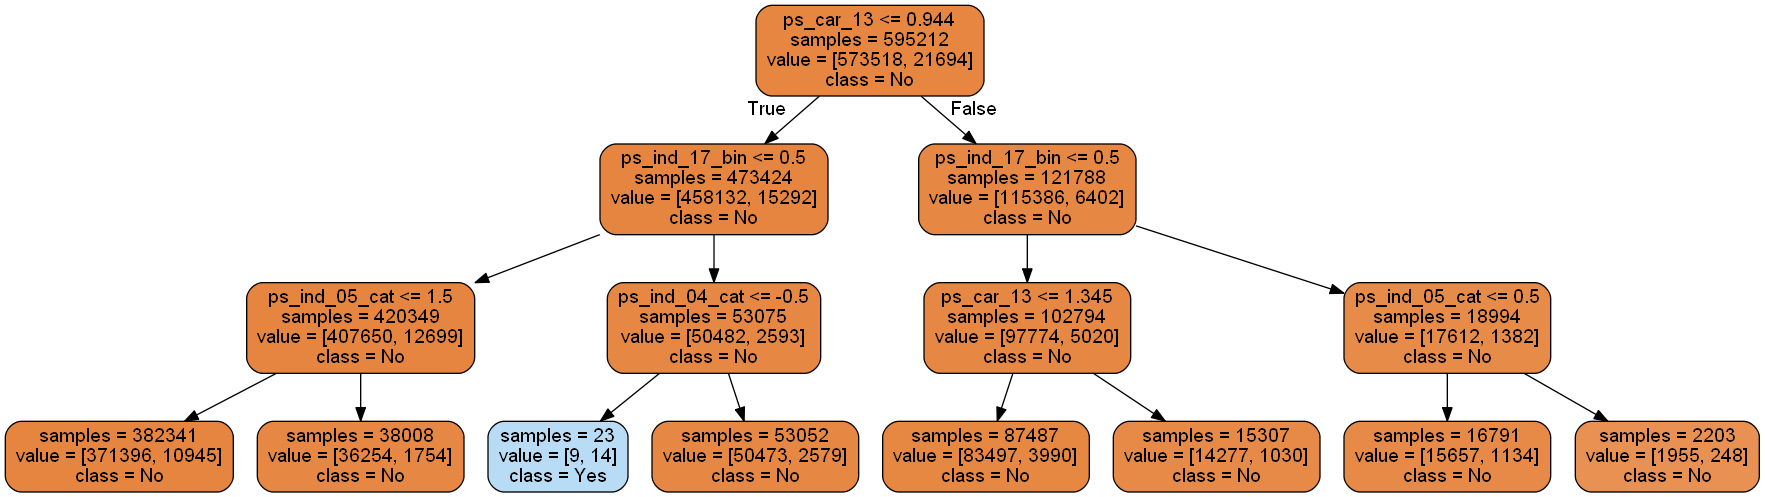

In [47]:
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

img = Image.open('./tree1.png')
draw = ImageDraw.Draw(img)
img.save('./sample-out.png')
PImage('./sample-out.png')


In [59]:
check_call(['echo',''])

FileNotFoundError: [WinError 2] 지정된 파일을 찾을 수 없습니다

In [48]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re
import pydot

decision_tree = tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(train.drop(['id', 'target'], axis=1), train.target)

# 훈련된 모델을 .dot 파일로 변환하기
with open('tree1.dot', 'w') as f:
    f = tree.export_graphviz(decision_tree,
                            out_file = f,
                            max_depth = 4,
                            impurity = False,
                            feature_names = train.drop(['id', 'target'], axis=1).columns.values,
                            class_names = ['No', 'Yes'],
                            rounded = True,
                            filled = True)
    
# .dot 파일을 .png 파일로 변환하여 웹 노트북에서 볼 수 있게 하기
rtn = check_call(['dot', '-Tpng', 'tree1.dot', '-o', 'tree1.png'])

print( rtn )
# Annoting chart with PIL
img = Image.open('./tree1.png')
draw = ImageDraw.Draw(img)
img.save('./sample-out.png')
PImage('./sample-out.png')

FileNotFoundError: [WinError 2] 지정된 파일을 찾을 수 없습니다